# Image Sensing Pipeline

<img style="float: left;" src="1.png" width="80%">

# In this homework ……

<img style="float: left;" src="2.png" width="80%">

In [153]:
import os
import cv2
import math
import random
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tone_mapping import tone_mapping
from color_correction import BGR2RGB, RGB2BGR, RGB2XYZ, XYZ2RGB, color_correction
from demosaic_and_mosaic import mosaic, demosaic
from white_balance import generate_wb_mask

# 1. Camera  Parameters

## 1.1 Import Data from tone_curves

In [154]:
curve_path = './'
curve_name = os.path.join(curve_path, 'tone_curves.mat')
curve_inv_name = os.path.join(curve_path, 'tone_curves_inv.mat')
tone_curves = scipy.io.loadmat(curve_name)
tone_curves_inv = scipy.io.loadmat(curve_inv_name)

In [155]:
I = tone_curves['I'] # Irradiance
B = tone_curves['B'] # Brightness
I_inv = tone_curves_inv['invI']
B_inv = tone_curves_inv['invB']

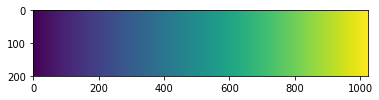

In [156]:
plt.imshow(I)

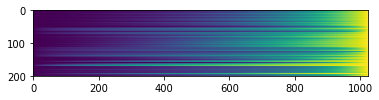

In [157]:
plt.imshow(I_inv)

## 1.2 Color Correction Matrix

In [158]:
ccm = np.array([1.0234, -0.2969, -0.2266, 
                -0.5625, 1.6328, -0.0469, 
                -0.0703, 0.2188, 0.6406])
ccm = np.reshape(ccm, (3, 3))
#ccm = ccm / np.tile(np.sum(ccm, axis=1), [3, 1]).T
ccm = (ccm / np.tile(np.sum(ccm, axis=1), [3, 1]).T).T
ccm_inv = np.linalg.inv(np.copy(ccm))

In [159]:
tone_index = 170  
fr = 0.7715567349551743
fb = 0.9068480239589546

# 2.  Load Image by OpenCV  

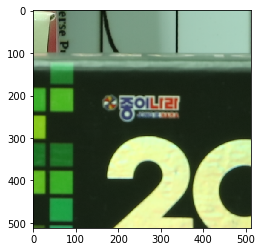

In [160]:
img = cv2.imread('.//images/1.png')
img_gt = img
np.array(img, dtype='uint8')
img = img.astype('double') / 255.0

#### Remember that the image store in OpenCV is BGR instead of RGB
#### We should transfer to RGB first before ISP
img = BGR2RGB(img)
plt.imshow(img)

# 3. Inverse ISP Process

## 3.1 Tone Mapping

In [161]:
img = tone_mapping(img, I_inv, B_inv, index=tone_index, inv=True)

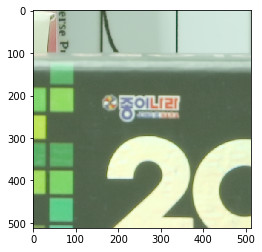

In [162]:
plt.imshow(img)

## 3.2 from RGB to CIE XYZ

<img style="float: left;" src="3.png" width="60%">

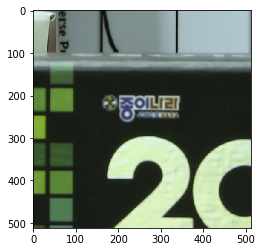

In [163]:
#from color_correction import RGB2XYZ
img = RGB2XYZ(img)
plt.imshow(img)

## 3.3. Color Correction

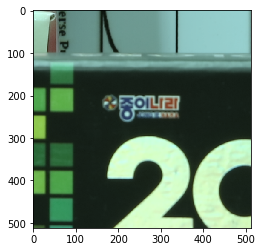

In [164]:
img = color_correction(img, ccm)
plt.imshow(img)

## 3.4 Mosaic

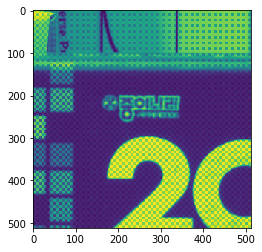

In [165]:
from demosaic_and_mosaic import mosaic, demosaic
pattern='RGGB'
img = mosaic(img, pattern=pattern)
plt.imshow(img)

## 3.5 Inverse AWB
1. Create a numpy array with shape of input RAW image.
2. According to the given Bayer pattern, fill the fr into  correspinding red channel position and fb into correspinding  blue channel position. Fill 1 into green channel position otherwise.  

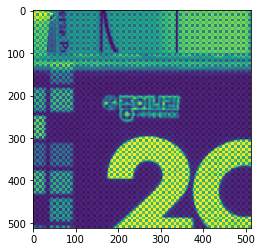

In [166]:
from white_balance import generate_wb_mask
fr = 0.7715567349551743
fb = 0.9068480239589546
wb_mask = generate_wb_mask(img, pattern, fr, fb)
img = img * wb_mask
plt.imshow(img)

In [167]:
img.shape

(512, 512)

In [168]:
img

array([[ 0.55296413,  0.85533056,  0.54579908, ...,  0.6586039 ,
         0.34065516,  0.50531062],
       [ 0.89010259,  0.74685216,  0.88227535, ...,  0.57331932,
         0.62177111,  0.43255936],
       [ 0.57486543,  0.92049856,  0.57164444, ...,  0.65481263,
         0.34331195,  0.50542302],
       ..., 
       [ 0.37852225,  0.19176436,  0.37885783, ...,  0.66508547,
         0.96429003,  0.66137186],
       [ 0.19688963,  0.38569281,  0.20153961, ...,  0.96419012,
         0.63587507,  0.95980556],
       [ 0.39004572,  0.18650407,  0.39400235, ...,  0.6612256 ,
         0.95980556,  0.6612256 ]])

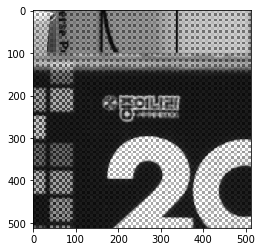

In [169]:
plt.imshow(img,cmap = 'gray')

# 4. ISP Process

## 4.1 AWB

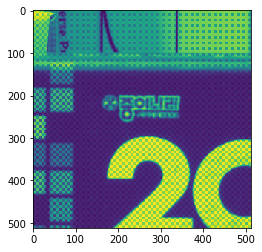

In [170]:
wb_mask = generate_wb_mask(img, pattern, 1/fr, 1/fb)
img = img * wb_mask
img = np.clip(img, 0, 1)
plt.imshow(img)

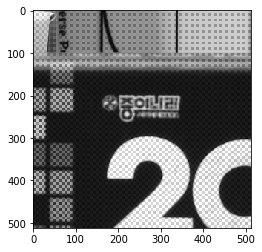

In [171]:
plt.imshow(img,cmap = 'gray')

## 4.2 Demosaic

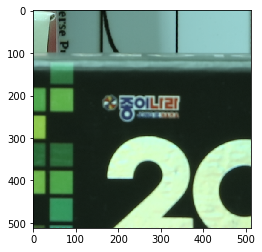

In [172]:
img = demosaic(img, pattern=pattern) #pattern='RGGB'
plt.imshow(img)

## 4.3 Color Correction

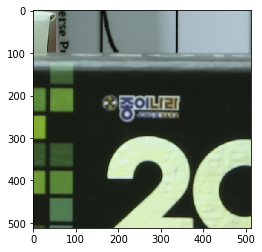

In [173]:
img = color_correction(img, ccm_inv)
plt.imshow(img)

## 4.4 XYZ2RGB

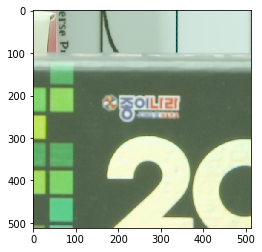

In [130]:
img = XYZ2RGB(img)
plt.imshow(img)

## 4.5 tone_mapping

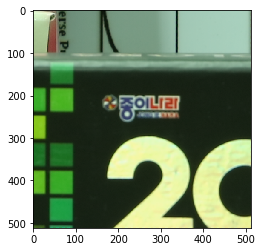

In [131]:
img = tone_mapping(img, I, B, index=tone_index, inv=False)
plt.imshow(img)

## 4.6 RGB2BGR

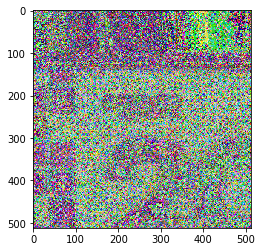

In [132]:
img = RGB2BGR(img) * 255.0
plt.imshow(img)

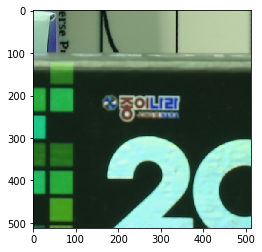

In [133]:
test = img / 255.0
plt.imshow(test)

## Peak signal-to-noise ratio
峰值信噪比（英語：Peak signal-to-noise ratio，常縮寫為PSNR）是一個表示信號最大可能功率和影響它的表示精度的破壞性雜訊功率的比值的工程術語。由於許多信號都有非常寬的動態範圍，峰值信噪比常用對數分貝單位來表示。峰值信噪比經常用作圖像壓縮等領域中信號重建質量的測量方法，它常簡單地通過均方誤差（MSE）進行定義。兩個m×n單色圖像I和K，如果一個為另外一個的噪聲近似，那麼它們的的均方誤差定義如下圖:

對於每點有RGB三個值的彩色圖像來說峰值信噪比的定義類似，只是均方誤差是所有方差之和除以圖像尺寸再除以 3。圖像壓縮中典型的峰值信噪比值在 30 到 40dB 之間，**愈高愈好**。

<img style="float: left;" src="4.png" width="55%">

In [134]:
def calculate_psnr(img1, img2):
    '''
    Input:
        img1, img2: H*W*3 numpy array
    Output:
        psnr: the peak signal-to-noise ratio value
    '''
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    psnr = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return psnr

In [135]:
calculate_psnr(img, img_gt)

40.615569796454956

In [ ]:
# test

In [137]:
def masks_CFA_Bayer_test(shape, pattern='RGGB'):

    pattern = pattern.upper()

    channels = dict((channel, np.zeros(shape)) for channel in 'RGB')
    for channel, (y, x) in zip(pattern, [(0, 0), (0, 1), (1, 0), (1, 1)]):
        channels[channel][y::2, x::2] = 1

    return tuple(channels[c].astype(bool) for c in 'RGB')

In [182]:
masks_CFA_Bayer_test((4,4),'RGGB')[0]

array([[ True, False,  True, False],
       [False, False, False, False],
       [ True, False,  True, False],
       [False, False, False, False]], dtype=bool)

In [183]:
masks_CFA_Bayer_test((4,4),'GRBG')[0]

array([[False,  True, False,  True],
       [False, False, False, False],
       [False,  True, False,  True],
       [False, False, False, False]], dtype=bool)

In [149]:
R_m, G_m, B_m = masks_CFA_Bayer_test((1,2),'GRBG')

In [150]:
R_m

array([[False,  True]], dtype=bool)

In [151]:
G_m

array([[ True, False]], dtype=bool)

In [152]:
B_m 

array([[False, False]], dtype=bool)